# RANDOM FOREST MODEL BUILD

In [82]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil  
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import joblib


# Function to measure CPU, Memory, and Disk I/O usage
def measure_system_resources():
    cpu_usage = psutil.cpu_percent(interval=1)
    memory_info = psutil.virtual_memory()
    disk_io = psutil.disk_io_counters()
    
    memory_used = memory_info.used / (1024 * 1024)  # Convert to MB
    disk_io_used = (disk_io.read_bytes + disk_io.write_bytes) / (1024 * 1024)  # Convert to MB
    
    return cpu_usage, memory_used, disk_io_used

In [83]:
# Step 1: Load Train and Test Datasets
train_data = pd.read_csv('../../2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/train.csv')
test_data = pd.read_csv('../../2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/test.csv')

 # Splitting features and labels

In [84]:
X_train = train_data.drop(['label'], axis=1)  # Features
y_train = train_data['label']  # Target variable
X_test = test_data.drop(['label'], axis=1)  # Features
y_test = test_data['label']  # Target variable

# Splitting training set for validation

In [85]:
# Step 2: Splitting training set for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Visualizing PCA Data

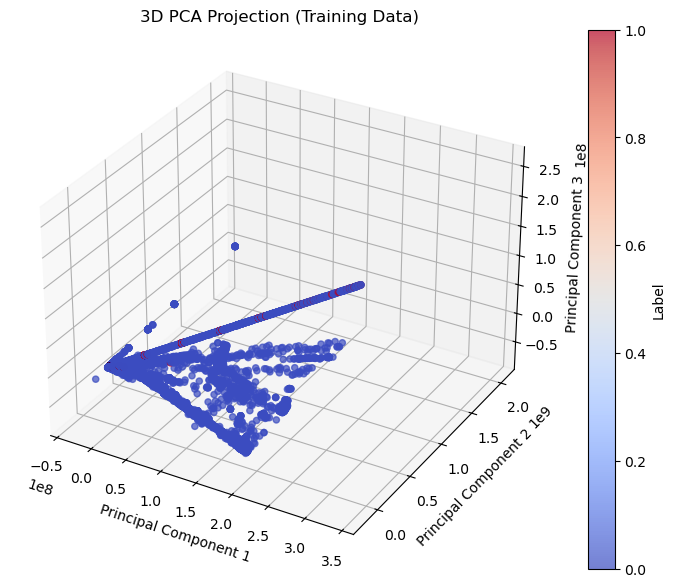

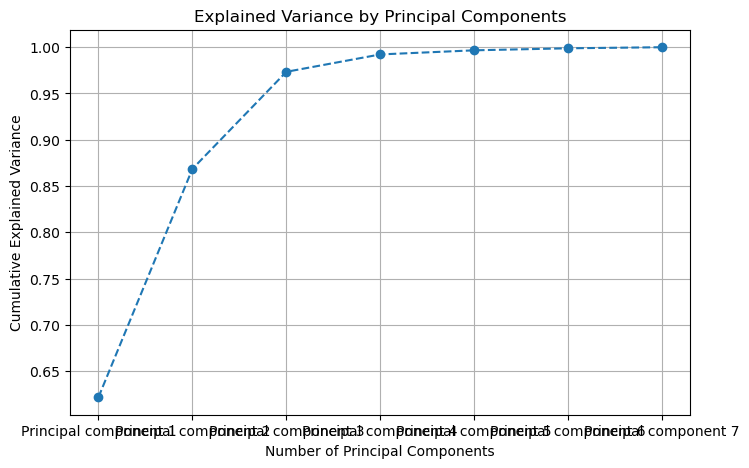

In [86]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_train.iloc[:, 0], X_train.iloc[:, 1], X_train.iloc[:, 2], 
    c=y_train, cmap='coolwarm', alpha=0.7
)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("3D PCA Projection (Training Data)")

plt.colorbar(scatter, ax=ax, label='Label')
plt.show()



# Calculate explained variance ratio manually
explained_variance = np.var(X_train, axis=0) / np.sum(np.var(X_train, axis=0))

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid()
plt.show()


# Model Creation and Training

In [87]:
# Start time and resource tracking
start_time = time.time()
cpu_before, memory_before, disk_io_before = measure_system_resources()

# Step 3: Initialize and train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=500,  # Number of trees
    max_depth=10,      # Maximum depth of each tree
    random_state=42,   # Random seed for reproducibility
    n_jobs=-1          # Use all available processors
)
rf_model.fit(X_train, y_train)


# End time and resource tracking
end_time = time.time()
cpu_after, memory_after, disk_io_after = measure_system_resources()
execution_time = end_time - start_time

cpu_usage_change = cpu_after - cpu_before
memory_used = memory_after - memory_before
disk_io_used = disk_io_after - disk_io_before

num_trees = len(rf_model.estimators_)  # Count number of trees

# Report computational overhead
print("\n🚀 **Computational Overhead Report (Model Training)** 🚀")
print(f"⏳ **Execution Time:** {execution_time:.4f} seconds")
print(f"🔥 **CPU Usage Change:** {cpu_usage_change:.2f}%")
print(f"💾 **Disk I/O Usage:** {disk_io_used:.2f} MB")
print(f"📊 **Peak Memory Usage:** {memory_used:.2f} MB")
print(f"🌲 **Random Forest Complexity:** {num_trees} Trees")



🚀 **Computational Overhead Report (Model Training)** 🚀
⏳ **Execution Time:** 23.0137 seconds
🔥 **CPU Usage Change:** 4.00%
💾 **Disk I/O Usage:** 43.19 MB
📊 **Peak Memory Usage:** -86.99 MB
🌲 **Random Forest Complexity:** 500 Trees


In [88]:
# Step 5: Validate the model
y_val_pred = rf_model.predict(X_val)

In [89]:
# Metrics for validation
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='binary')
val_recall = recall_score(y_val, y_val_pred, average='binary')
val_f1 = f1_score(y_val, y_val_pred, average='binary')

In [90]:
print("Validation Results:")
print(f"Accuracy:   {val_accuracy:.2%}")
print(f"Precision:  {val_precision:.2%}")
print(f"Recall:     {val_recall:.2%}")
print(f"F1-score:   {val_f1:.2%}")

Validation Results:
Accuracy:   99.81%
Precision:  99.76%
Recall:     99.89%
F1-score:   99.83%


# Test the Model

In [91]:
# Start time and resource tracking
start_time = time.time()
cpu_before, memory_before, disk_io_before = measure_system_resources()

# Step 6: Test the model
y_test_pred = rf_model.predict(X_test)

In [92]:
# Metrics for test dataset
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='binary')
test_recall = recall_score(y_test, y_test_pred, average='binary')
test_f1 = f1_score(y_test, y_test_pred, average='binary')

# End time and resource tracking
end_time = time.time()
cpu_after, memory_after, disk_io_after = measure_system_resources()
execution_time = end_time - start_time

cpu_usage_change = cpu_after - cpu_before
memory_used = memory_after - memory_before
disk_io_used = disk_io_after - disk_io_before

print("Test Results:")
print(f"Accuracy:   {test_accuracy:.2%}")
print(f"Precision:  {test_precision:.2%}")
print(f"Recall:     {test_recall:.2%}")
print(f"F1-score:   {test_f1:.2%}")

# Report computational overhead
print("\n **Computational Overhead Report (Model Testing)** 🚀")
print(f" **Execution Time:** {execution_time:.4f} seconds")
print(f" **CPU Usage Change:** {cpu_usage_change:.2f}%")
print(f" **Disk I/O Usage:** {disk_io_used:.2f} MB")
print(f" **Memory Usage:** {memory_used:.2f} MB")

Test Results:
Accuracy:   99.68%
Precision:  99.71%
Recall:     99.72%
F1-score:   99.71%

 **Computational Overhead Report (Model Testing)** 🚀
 **Execution Time:** 1.2115 seconds
 **CPU Usage Change:** 7.70%
 **Disk I/O Usage:** 0.36 MB
 **Memory Usage:** 30.53 MB


# Confusion Metrix

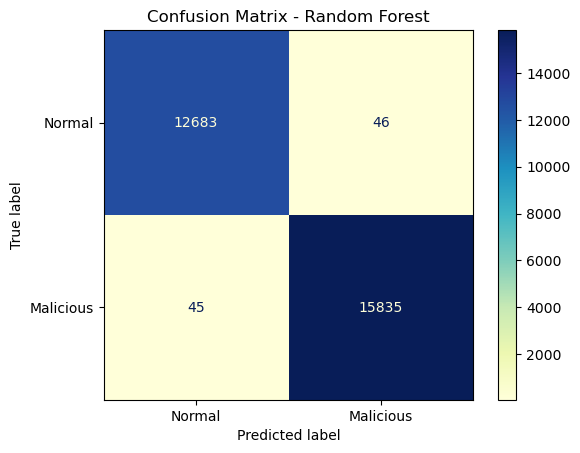

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12729
           1       1.00      1.00      1.00     15880

    accuracy                           1.00     28609
   macro avg       1.00      1.00      1.00     28609
weighted avg       1.00      1.00      1.00     28609



In [93]:
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Malicious'])

disp.plot(cmap='YlGnBu', values_format='d')

plt.title('Confusion Matrix - Random Forest')
plt.show()


# Classification report
print(classification_report(y_test, y_test_pred))

# Save the Trained Model

In [94]:
# Step 4: Save the trained model
model_folder = "../../3_Post-Modeling-Phase/Trained_ML_models/Models_CICIDS-2017/"
model_filename = "CICIDS-2017_RandomForest.joblib"
model_path = model_folder + model_filename
joblib.dump(rf_model, model_path)
print(f"Random Forest model saved to: {model_path}")

Random Forest model saved to: ../../3_Post-Modeling-Phase/Trained_ML_models/Models_CICIDS-2017/CICIDS-2017_RandomForest.joblib
